C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


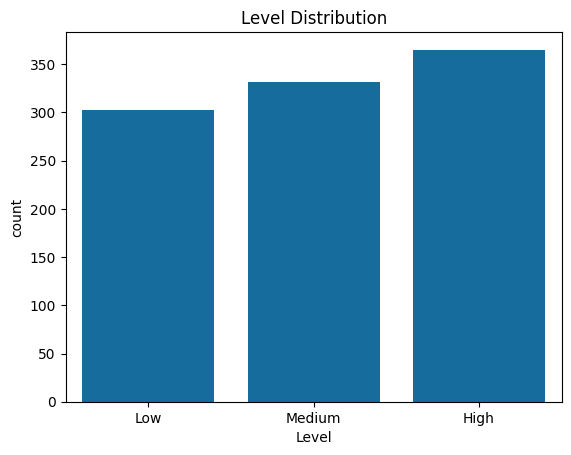

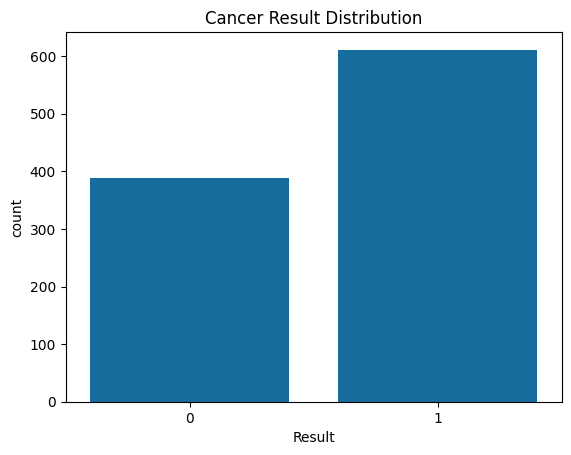

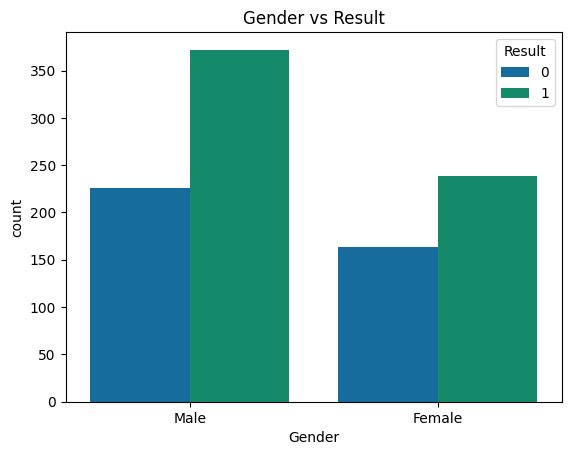

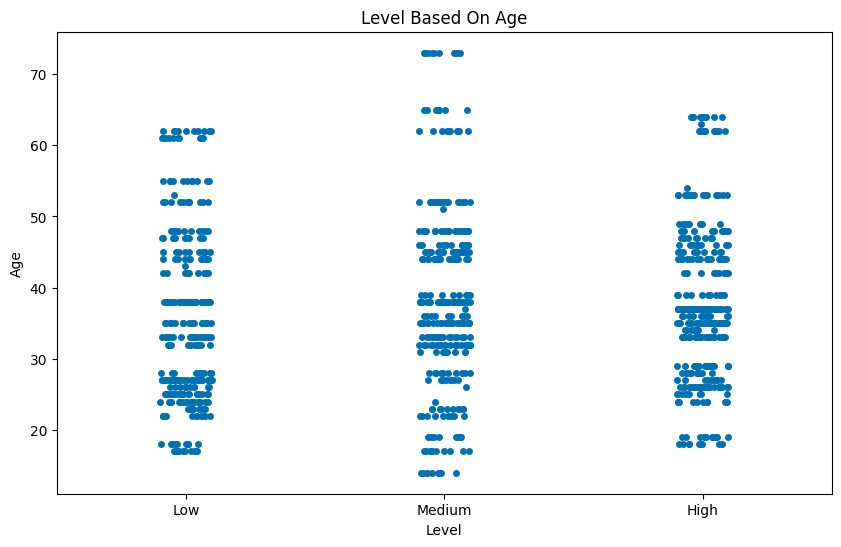

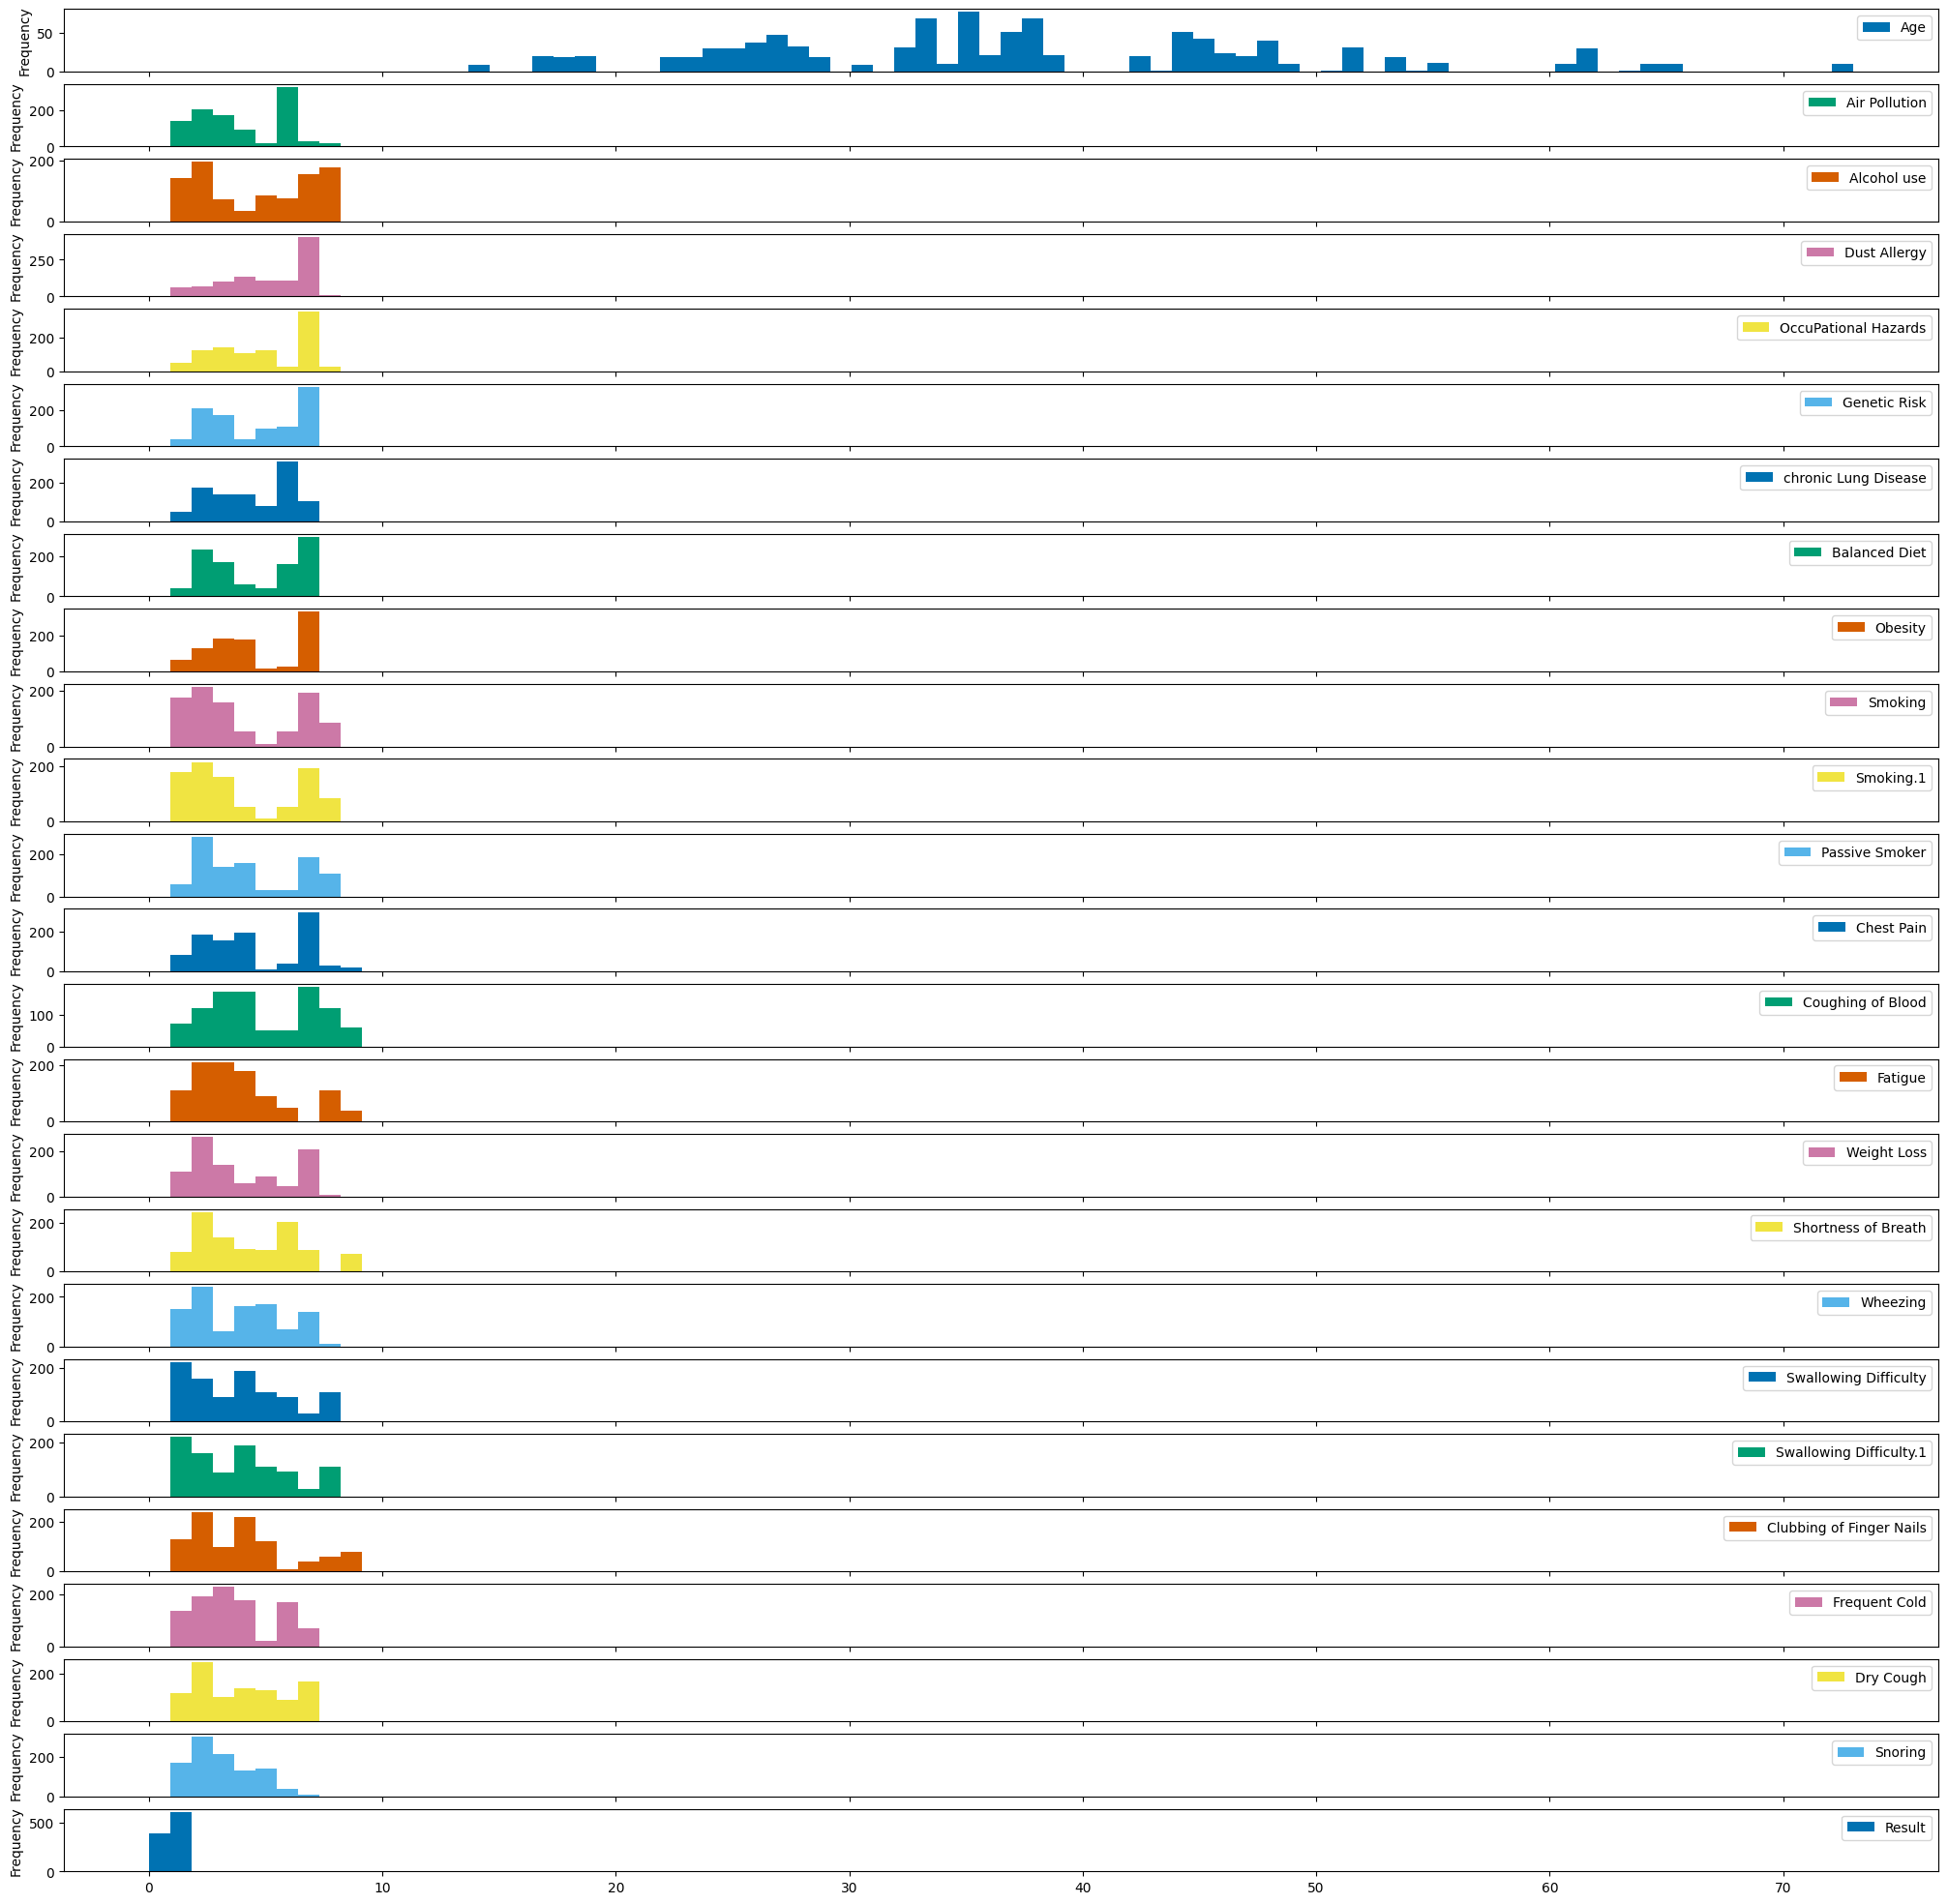

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient Id                1000 non-null   object 
 1   Age                       1000 non-null   int64  
 2   Gender                    1000 non-null   object 
 3   Air Pollution             1000 non-null   int64  
 4   Alcohol use               936 non-null    float64
 5   Dust Allergy              1000 non-null   int64  
 6   OccuPational Hazards      950 non-null    float64
 7   Genetic Risk              1000 non-null   int64  
 8   chronic Lung Disease      1000 non-null   int64  
 9   Balanced Diet             1000 non-null   int64  
 10  Obesity                   936 non-null    float64
 11  Smoking                   944 non-null    float64
 12  Smoking.1                 944 non-null    float64
 13  Passive Smoker            1000 non-null   int64  
 14  Chest Pai

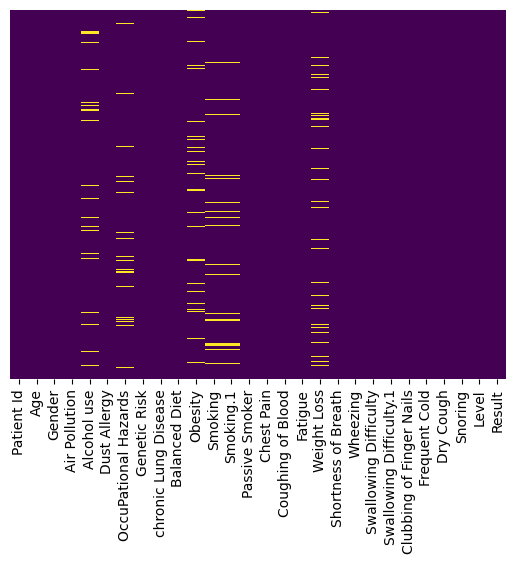

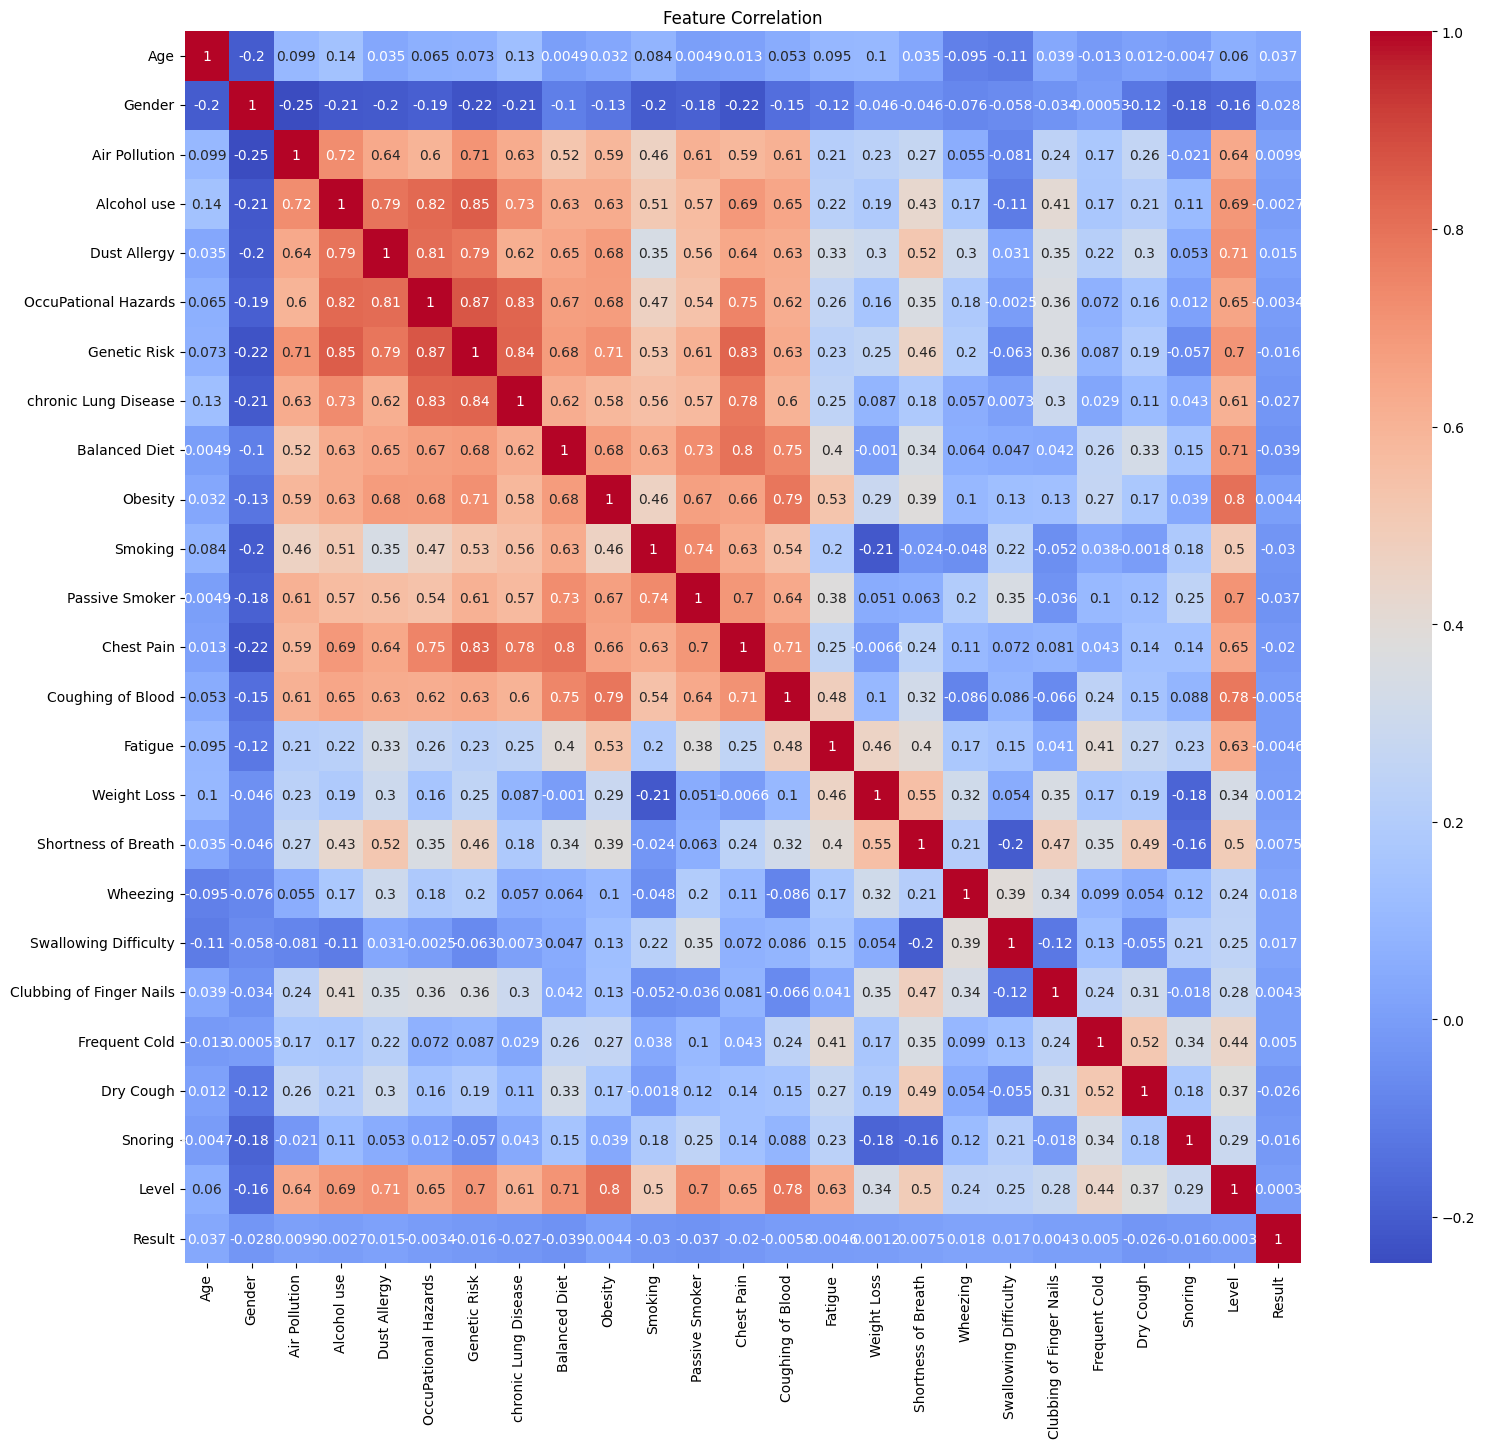

Train shape: (800, 22) | Test shape: (200, 22)

DecisionTree - Train acc: 0.75, Test acc: 0.48
NaiveBayes - Train acc: 0.61, Test acc: 0.60
RandomForest - Train acc: 0.75, Test acc: 0.51
SVM - Train acc: 0.63, Test acc: 0.59
KNN - Test acc: 0.47


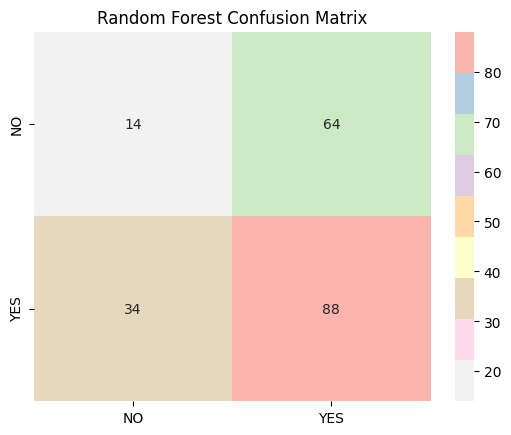


Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.18      0.22        78
           1       0.58      0.72      0.64       122

    accuracy                           0.51       200
   macro avg       0.44      0.45      0.43       200
weighted avg       0.47      0.51      0.48       200


=== Running SHAP Explainability on Random Forest ===
✅ Final SHAP array shape: (200, 22)


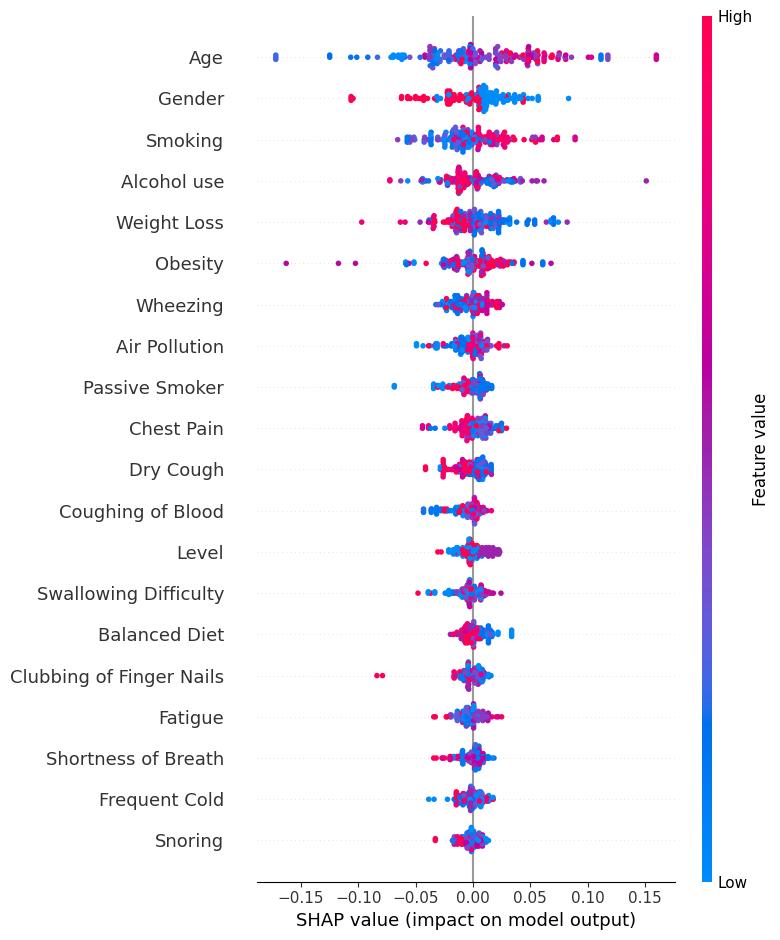

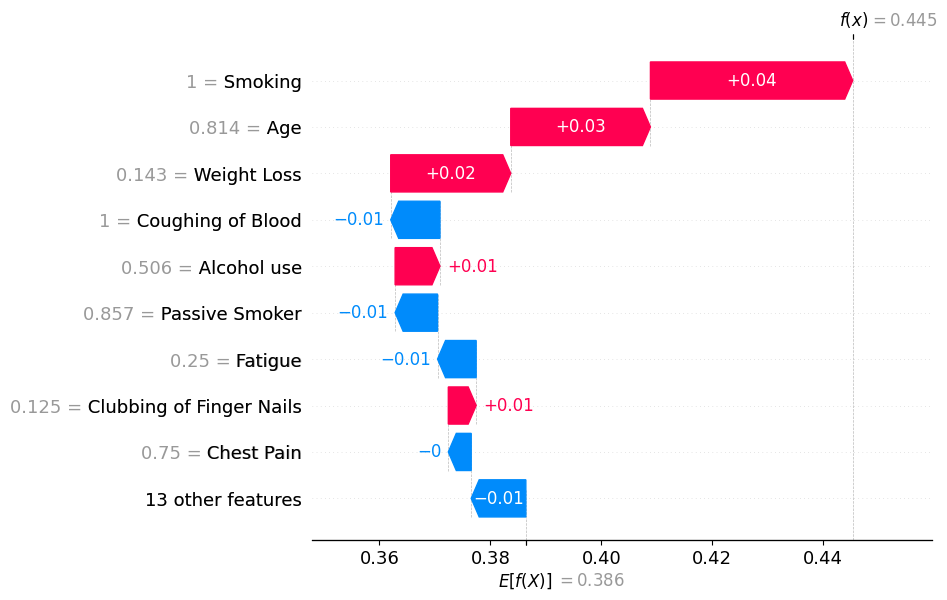

✅ SHAP analysis finished successfully.

✅ Model and Scaler saved successfully as 'lung_cancer_model.pkl' and 'scaler.pkl'.


In [ ]:
# ===============================================================
# 📘 LUNG CANCER PREDICTION + SHAP EXPLAINABILITY (CLEAN VERSION)
# ===============================================================

# --- IMPORTS ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import shap
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-colorblind')

# ===============================================================
# 1️⃣ LOAD DATA
# ===============================================================
dataset = pd.read_csv("lung cancer dataset (updated).csv")

# ===============================================================
# 2️⃣ VISUALIZATION
# ===============================================================
sns.countplot(data=dataset, x='Level')
plt.title('Level Distribution')
plt.show()

sns.countplot(data=dataset, x='Result')
plt.title('Cancer Result Distribution')
plt.show()

sns.countplot(x="Gender", hue="Result", data=dataset)
plt.title("Gender vs Result")
plt.show()

plt.figure(figsize=(10,6))
sns.stripplot(x="Level", y="Age", data=dataset, jitter=True)
plt.title('Level Based On Age')
plt.show()

dataset.plot.hist(subplots=True, figsize=(25,25), bins=80)
plt.show()

# ===============================================================
# 3️⃣ DATA CLEANING
# ===============================================================
dataset.info()
sns.heatmap(dataset.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

# Drop duplicate/unimportant columns
dataset.drop(['Patient Id', 'Smoking.1', 'Swallowing Difficulty.1'], axis=1, inplace=True)

# ===============================================================
# 4️⃣ IMPUTE MISSING VALUES
# ===============================================================
cols_to_impute = ['Alcohol use', 'OccuPational Hazards', 'Obesity', 'Smoking', 'Weight Loss']
imputer = SimpleImputer(strategy='mean')
dataset[cols_to_impute] = imputer.fit_transform(dataset[cols_to_impute])

# ===============================================================
# 5️⃣ ENCODE CATEGORICAL FEATURES
# ===============================================================
dataset['Level'] = dataset['Level'].map({'Low':0, 'Medium':1, 'High':2})
dataset['Gender'] = dataset['Gender'].map({'Male':0, 'Female':1})

# ===============================================================
# 6️⃣ CORRELATION HEATMAP
# ===============================================================
plt.figure(figsize=(18,16))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

# Drop less important correlated columns
newdata = dataset.drop(["Genetic Risk", "OccuPational Hazards"], axis=1)

# ===============================================================
# 7️⃣ TRAIN-TEST SPLIT + SCALING
# ===============================================================
X = newdata.drop(['Result'], axis=1)
y = newdata['Result']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

scaler = MinMaxScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# ===============================================================
# 8️⃣ MODEL TRAINING + EVALUATION
# ===============================================================

# --- Decision Tree ---
clf = DecisionTreeClassifier(random_state=42)
clf.fit(scaled_X_train, Y_train)
print("\nDecisionTree - Train acc: {:.2f}, Test acc: {:.2f}".format(
    clf.score(scaled_X_train, Y_train), clf.score(scaled_X_test, Y_test)))

# --- Naive Bayes ---
gnb = GaussianNB()
gnb.fit(scaled_X_train, Y_train)
print("NaiveBayes - Train acc: {:.2f}, Test acc: {:.2f}".format(
    gnb.score(scaled_X_train, Y_train), gnb.score(scaled_X_test, Y_test)))

# --- Random Forest ---
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(scaled_X_train, Y_train)
print("RandomForest - Train acc: {:.2f}, Test acc: {:.2f}".format(
    rfc.score(scaled_X_train, Y_train), rfc.score(scaled_X_test, Y_test)))

# --- SVM ---
svm = SVC()
svm.fit(scaled_X_train, Y_train)
print("SVM - Train acc: {:.2f}, Test acc: {:.2f}".format(
    svm.score(scaled_X_train, Y_train), svm.score(scaled_X_test, Y_test)))

# --- KNN ---
knn = KNeighborsClassifier()
knn.fit(scaled_X_train, Y_train)
print("KNN - Test acc: {:.2f}".format(knn.score(scaled_X_test, Y_test)))

# ===============================================================
# 9️⃣ RANDOM FOREST CONFUSION MATRIX
# ===============================================================
predictions = rfc.predict(scaled_X_test)
mat = confusion_matrix(Y_test, predictions)

sns.heatmap(mat, cmap="Pastel1_r",
            xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'], annot=True)
plt.title("Random Forest Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(Y_test, predictions))

# ===============================================================
# 🔟 SHAP FEATURE EXPLANATION
# ===============================================================
# ===============================================================
# 🔟 SHAP FEATURE EXPLANATION
# ===============================================================
print("\n=== Running SHAP Explainability on Random Forest ===")

# Recreate DataFrame for SHAP
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=X.columns, index=X_test.index)

explainer = shap.TreeExplainer(rfc)

# Compute SHAP values
try:
    shap_values = explainer.shap_values(scaled_X_test_df)
except Exception as e:
    print("TreeExplainer.shap_values failed:", e)
    shap_values = explainer(scaled_X_test_df).values

# --- Handle multiple outputs ---
if isinstance(shap_values, list):
    # For classification models, choose the positive class (1)
    shap_array = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    # If it's 3D (samples × features × classes), select last dimension = 1
    shap_array = shap_values
    if shap_array.ndim == 3:
        shap_array = shap_array[:, :, 1]  # pick SHAP values for positive class

# --- Sanity check ---
assert shap_array.shape == scaled_X_test_df.shape, \
    f"SHAP shape {shap_array.shape} != data shape {scaled_X_test_df.shape}"

print("✅ Final SHAP array shape:", shap_array.shape)

# --- Global SHAP summary plot ---
shap.summary_plot(shap_array, scaled_X_test_df, feature_names=scaled_X_test_df.columns)

# --- Waterfall plot for first sample ---
# --- Waterfall plot for first sample ---
sample_idx = 0

# Safely handle scalar vs array for base value
base_val = explainer.expected_value
if isinstance(base_val, list):
    base_val = base_val[1]  # positive class
if isinstance(base_val, (np.ndarray, list)):
    base_val = float(np.ravel(base_val)[0])

# Build SHAP Explanation object
expl = shap.Explanation(
    values=shap_array[sample_idx],
    base_values=base_val,
    data=scaled_X_test_df.iloc[sample_idx],
    feature_names=scaled_X_test_df.columns
)

# Plot
shap.plots.waterfall(expl)
print("✅ SHAP analysis finished successfully.")



# ===============================================================
# 1️⃣1️⃣ SAVE MODEL + SCALER
# ===============================================================
joblib.dump(scaler, "scaler.pkl")
joblib.dump(rfc, "lung_cancer_model.pkl")
print("\n✅ Model and Scaler saved successfully as 'lung_cancer_model.pkl' and 'scaler.pkl'.")


In [2]:
# Save column names used during training
joblib.dump(list(X.columns), "feature_columns.pkl")


['feature_columns.pkl']